#HW 10 CLUSTERING BUSINESS

#cluster time trends in NYC businesses: 
#DATA
#Census Business data:
##download census data for businesses by ZIP code. the data is here
http://www.census.gov/econ/cbp/download/
##and it can be downloaded by hand. you can also download it with 3 terminal commands as follows: the data from 1993 through 2001 is different in the format of its path than the data after 2001 (that is why more than one for loop is needed)



In [ ]:
#$ for ((y=93; y<=99; y+=1)); do wget ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp$y\totals.zip; done

#$ for ((y=0; y<=9; y+=1)); do wget ftp://ftp.census.gov/econ200$y\/CBP_CSV/zbp0$y\totals.zip; done

#$ for ((y=10; y<=15; y+=1)); do wget ftp://ftp.census.gov/econ20$y\/CBP_CSV/zbp$y\totals.zip; done


#NYC zip codes shape file is here
##http://data.nycprepared.org/dataset/nyc-zip-code-tabulation-areas/resource/0c0e14e9-78e1-404e-97b0-c2fabceb3981


NOTES: 
to read in a zip file without unzipping it you can use the pandas and zipfile packages

In [132]:
import pandas as pd

import zipfile #i am not giving it a name cause i intend to use it only once




In [ ]:
#zf = zipfile.ZipFile(fname)
#df = pd.read_csv(zf.open(fname.replace('.zip','.txt')))



you may need to clean your data: for some NYC zip codes there may be no info
    
sanity check: you should have 20 (Ntimestamps) datapoints per time series and about 250 zipcodes (Nzipcodes)

IMPORTANT: we talked about the importance of "whitening" your data: dividing each feature by its standard deviation. 
Whitenings decorrelates the data: it makes the features independent so that the data covariance matrix is the identity matrix.
Whitening your data in time series analysis is in most cases **wrong**: you are modifying your time behaviour. This is because of the strong correlation between features (two consecutive time stamps for the same observation, the same zip code here, are strongly correlated). Here instead you want to standardize your time series: subtract the mean and divide each time series (separately) by its standard deviation. As a sanity check (if you use skitlearn Kmeans or skitlearns kmeans2): you want your data array to be shaped Nzipcodes x Ntimestamps

mydata.shape should be (Nzipcodes, Ntimestamps)

mydata[i].std() shoould be 1 for all i in range(len(Nzipcodes))

mydata[i].mean() should be ~0 for all i in range(len(Nzipcodes))



TASKS:
    
    1. get and prep your data.
    2. cluster the NUMBER OF ESTABLISHMENTS time series with K-means in **a few** clusters (as discussed there is no real good, sound way to decide what a good number is here. try a few options, keeping in mind a few is more than a couple, but i recommand you stay within the single digit numbers)
    3. plot the cluster centers (if you used K means those are the means of the clusters). you can plot for example the cluster centers overlayed on each time series (using the alpha channel to control the opacity in the plot may be helpful here).
    4. Use another clustering algorithm (of your choice)
    5. overlay your data on a NYC map: you can use shapefiles for the zip codes and different colors for different clusters
    6. Compare the results of the 2 algorithms
    7. attempt an interpretation. this is dangerous ground: clustering is an exploratory tool so you do not want to jump to conclusions because you see some clusters! but seeing structure in your data can inform your next moves as an investigator. 
    

In [138]:
import pandas as pd
import zipfile 
import glob, os
import numpy as np
import pylab as pl
import json
from descartes import PolygonPatch
import sklearn.cluster
from sklearn import mixture
from PIL import Image
from scipy.misc import imread
from scipy.cluster.vq import kmeans2
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.cluster import AffinityPropagation

%pylab inline
kelly_colors_hex = [
    '#FFB300', # Vivid Yellow
    '#803E75', # Strong Purple
    '#FF6800', # Vivid Orange
    '#A6BDD7', # Very Light Blue
    '#C10020', # Vivid Red
    '#CEA262', # Grayish Yellow
    '#817066', # Medium Gray
    '#007D34', # Vivid Green
    '#F6768E', # Strong Purplish Pink
    '#00538A', # Strong Blue
    '#FF7A5C', # Strong Yellowish Pink
    '#53377A', # Strong Violet
    '#FF8E00', # Vivid Orange Yellow
    '#B32851', # Strong Purplish Red
    '#F4C800', # Vivid Greenish Yellow
    '#7F180D', # Strong Reddish Brown
    '#93AA00', # Vivid Yellowish Green
    '#593315', # Deep Yellowish Brown
    '#F13A13', # Vivid Reddish Orange
    '#232C16', # Dark Olive Green
    ]



Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


1. get and prep your data.

In [134]:
shapefile = json.load(open('nyc-zip-code-tabulation-areas-polygons.geojson'))

In [89]:
nyc_zip = []
for i in shapefile['features']:
    nyc_zip.append(str(i['properties']["postalCode"]))

In [131]:

#zf = zipfile.ZipFile(fname)
#df = pd.read_csv(zf.open(fname.replace('.zip','.txt')))

#Census Data and number of stablishments

os.chdir(".")
fname = "zbp94totals.zip"
#open as zip
zf = zipfile.ZipFile(fname)
#Change extension to open file in txt inside the zipfifle
df = pd.read_csv(zf.open(fname.replace('.zip','.txt')))
#same format to titles
df = df.rename(columns={'zip': 'ZIP', 'est': 'EST'})
frameZIP_year = df[['ZIP', 'EST']]
frameZIP_year = frameZIP_year[(frameZIP_year.ZIP.astype(str).isin(nyc_zip))]
frameZIP_year['YEAR'] = 1994


In [91]:

for fname in glob.glob("*.zip"):
    if fname == "zbp94totals.zip":
        continue
    zf = zipfile.ZipFile(fname)
    df = pd.read_csv(zf.open(fname.replace('.zip','.txt')))
    df = df.rename(columns={'zip': 'ZIP', 'est': 'EST'})
    df = df[['ZIP', 'EST']]
    df = df[(df.ZIP.astype(str).isin(nyc_zip))]
    #Get year from the name of the file
    if int(fname[3:5]) > 93:
        df['YEAR'] = int('19' + fname[3:5])
    else:
        df['YEAR'] = int('20' + fname[3:5])
    frameZIP_year = frameZIP_year.append(df, ignore_index=True)

In [93]:
frameZIP = frameZIP_year.pivot_table('EST',['ZIP'],'YEAR')

In [94]:
frameZIP.head()

YEAR   1994  1995  1996  1997  1998  1999  2000  2001  2002  2003  2004  2005  \
ZIP                                                                             
10001  6999  7088  7075  7154  7254  7233  7317  7188  7141  7084  7370  7312   
10002  1784  1819  1919  2049  2003  2085  2277  2543  2269  2402  2551  2682   
10003  3256  3377  3417  3535  3649  3659  3683  3602  3616  3704  3776  3867   
10004  1115  1124  1133  1173  1176  1233  1294  1247  1253  1252  1283  1260   
10005  1076  1109  1216  1227  1270  1242  1287  1249  1244  1200  1226  1214   

YEAR   2006  2007  2008  2009  2010  2011  2012  2013  
ZIP                                                    
10001  7415  7549  7472  7305  7241  7227  7235  7273  
10002  2686  2685  2691  2775  2872  2912  2954  2988  
10003  3909  4049  4071  4099  4113  4159  4214  4277  
10004  1311  1370  1376  1379  1398  1404  1442  1479  
10005  1259  1273  1291  1274  1266  1301  1273  1296

In [95]:
# Cleaning data
#substract mean divide standard dev(estandirized data)
clean_frameZIP = frameZIP.copy()
for i in range(len(frameZIP)):
    clean_frameZIP.iloc[i] = (clean_frameZIP.iloc[i]-np.mean(clean_frameZIP.iloc[i]))/np.std(clean_frameZIP.iloc[i])

In [135]:
# verify a zip
randomdzip = np.random.choice(np.array(clean_frameZIP.index))
print "zip: %s" %(randomdzip)
print("STD = {0}".format(np.std(clean_frameZIP.loc[randomdzip])))
print("MEAN = {0:.2f}".format(np.mean(clean_frameZIP.loc[randomdzip])))



zip: 10005
STD = 1.0
MEAN = -0.00


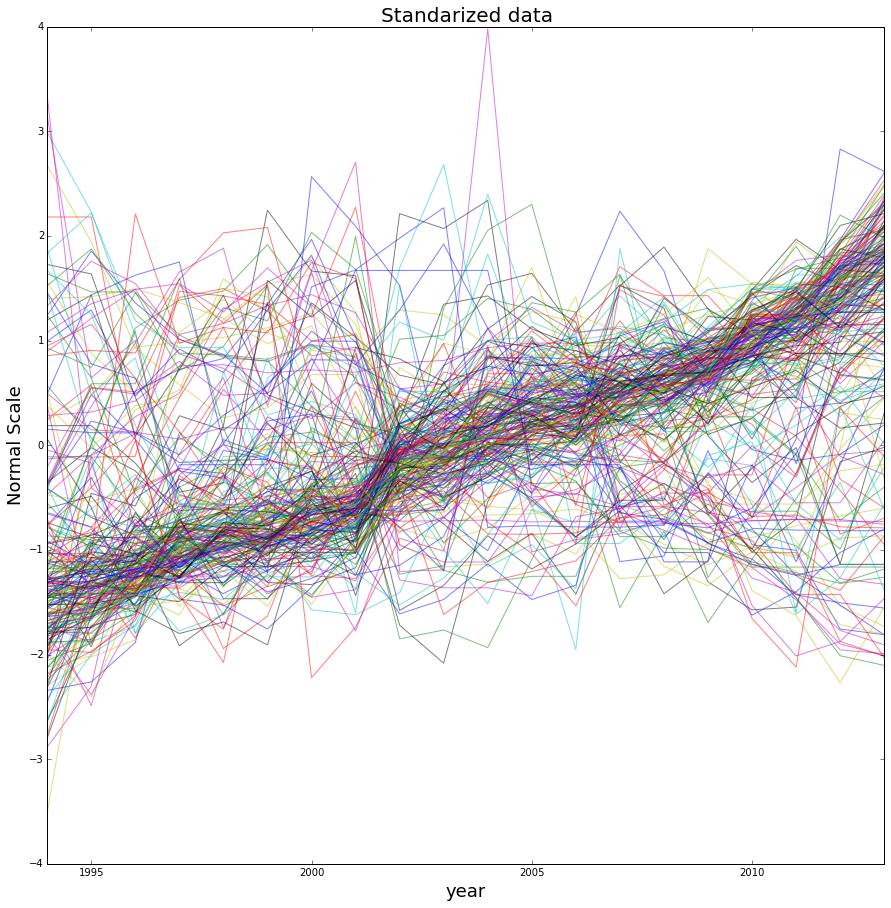

In [136]:
plt.figure(figsize=(15,15))
plt.xlim(1994,2013)
for i in range(len(clean_frameZIP)):
    plt.plot(clean_frameZIP.iloc[i].index, clean_frameZIP.iloc[i], '-', alpha=0.5)
    plt.title('Standarized data',fontsize=20)
    plt.xlabel('year',fontsize=18)
    plt.ylabel('Normal Scale',fontsize=18)
    



In [114]:
clean_frameZIP.head()

YEAR       1994      1995      1996      1997      1998      1999      2000  \
ZIP                                                                           
10001 -1.831632 -1.173250 -1.269418 -0.685012  0.054742 -0.100607  0.520787   
10002 -1.722813 -1.631907 -1.372173 -1.034519 -1.153997 -0.941015 -0.442326   
10003 -1.872528 -1.457250 -1.319968 -0.914985 -0.523731 -0.489411 -0.407041   
10004 -1.608897 -1.523770 -1.438643 -1.060302 -1.031926 -0.492790  0.084181   
10005 -2.885957 -2.304004 -0.417066 -0.223082  0.535220  0.041442  0.835014   

YEAR       2001      2002      2003      2004      2005      2006      2007  \
ZIP                                                                           
10001 -0.433496 -0.781180 -1.202840  0.912857  0.483799  1.245746  2.237017   
10002  0.248565 -0.463105 -0.117659  0.269344  0.609595  0.619984  0.617387   
10003 -0.685038 -0.636989 -0.334968 -0.087861  0.224456  0.368602  0.849090   
10004 -0.360370 -0.303619 -0.313078 -0.019863 -0.237409  0.244976  0.803030   
10005  0.164887  0.076712 -0.699225 -0.240717 -0.452336  0.341236  0.588125   

YEAR       2008      2009      2010      2011      2012      2013  
ZIP                                                                
10001  1.667406  0.432016 -0.041426 -0.144992 -0.085811  0.195295  
10002  0.632971  0.851147  1.103089  1.206982  1.316071  1.404380  
10003  0.924595  1.020693  1.068741  1.226616  1.415379  1.631598  
10004  0.859781  0.888157  1.067869  1.124620  1.484044  1.834010  
10005  0.905554  0.605760  0.464681  1.081903  0.588125  0.993729

In [115]:
clean_frameZIP = clean_frameZIP.dropna()

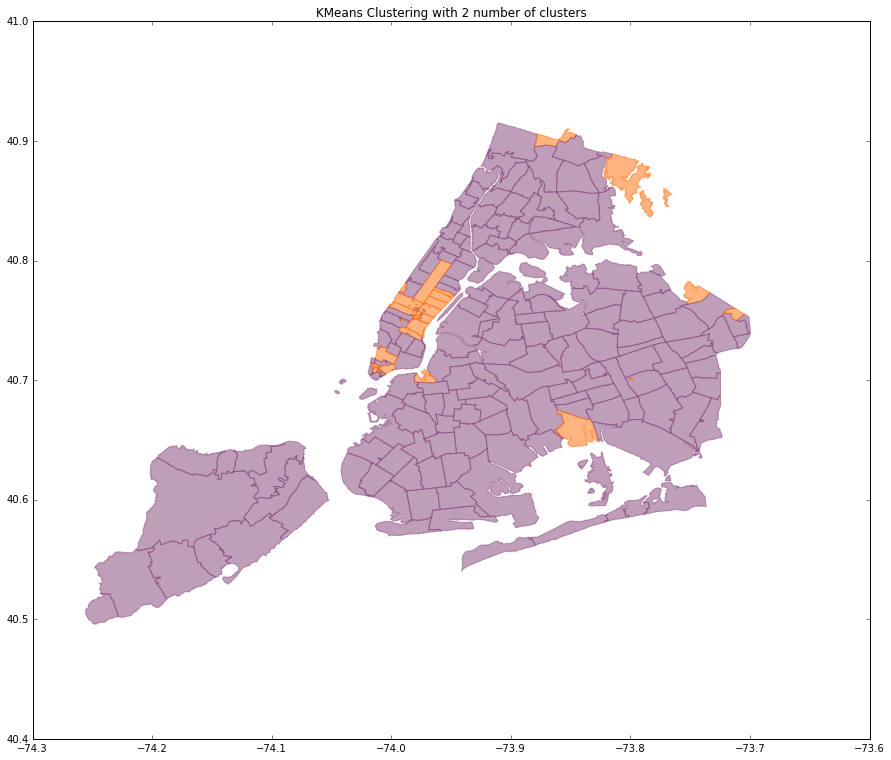

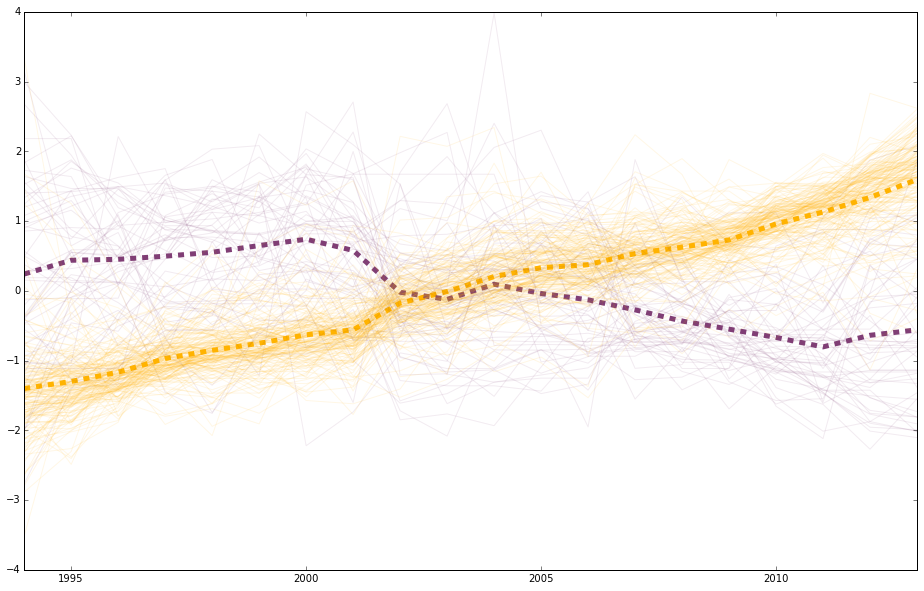

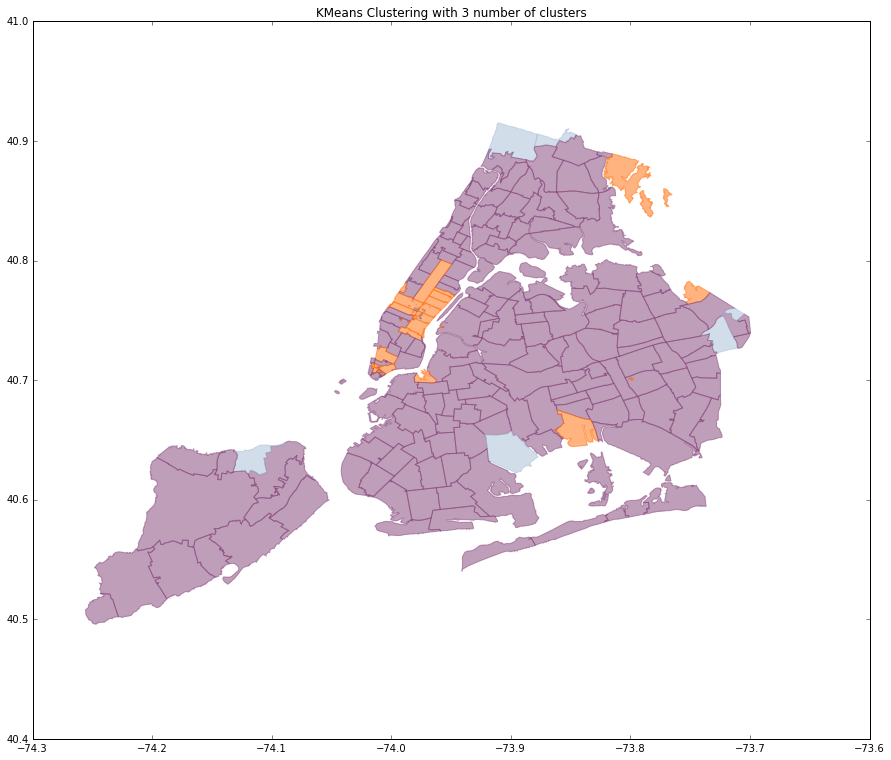

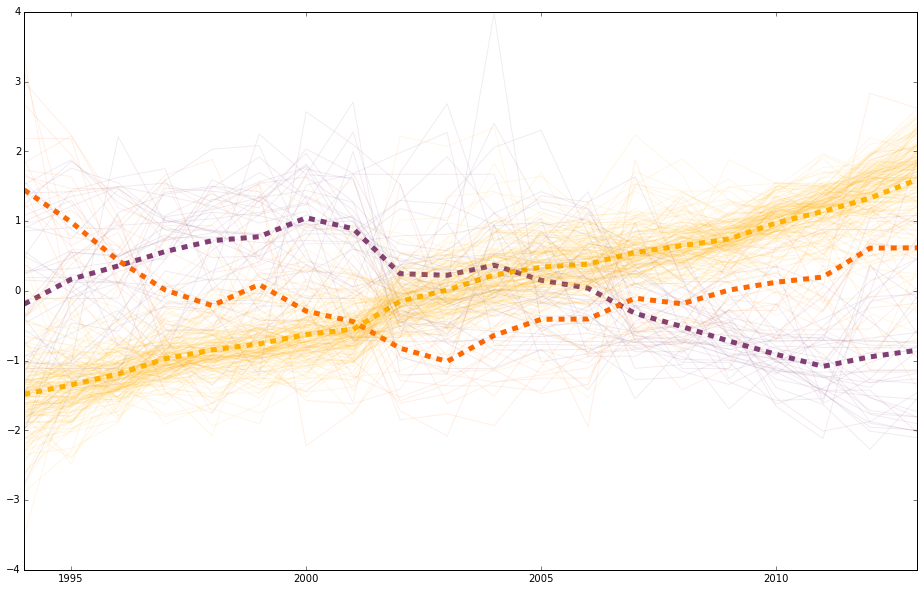

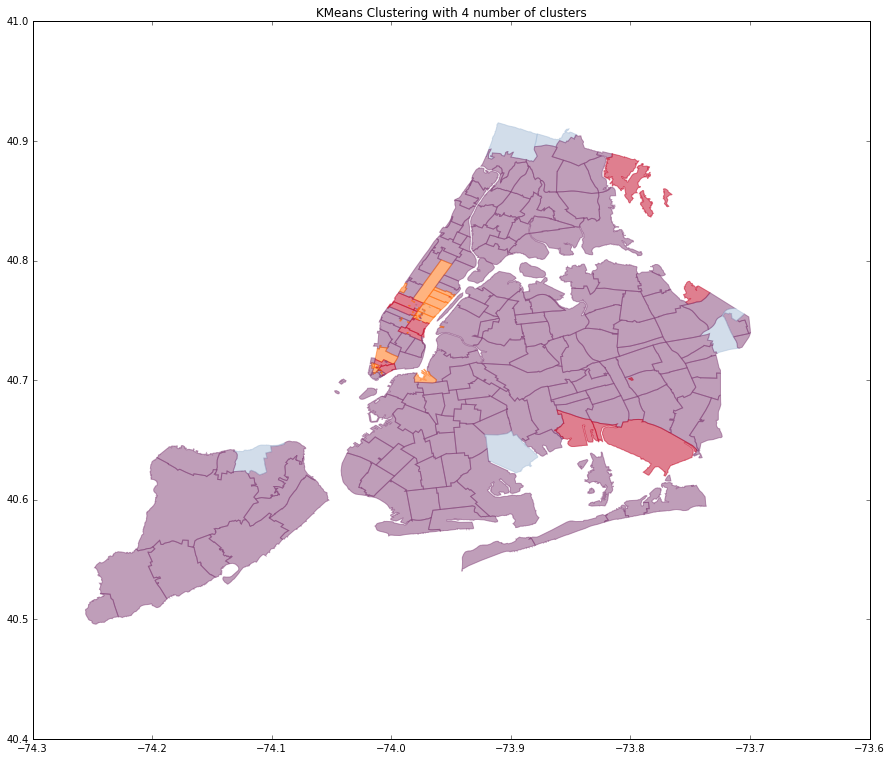

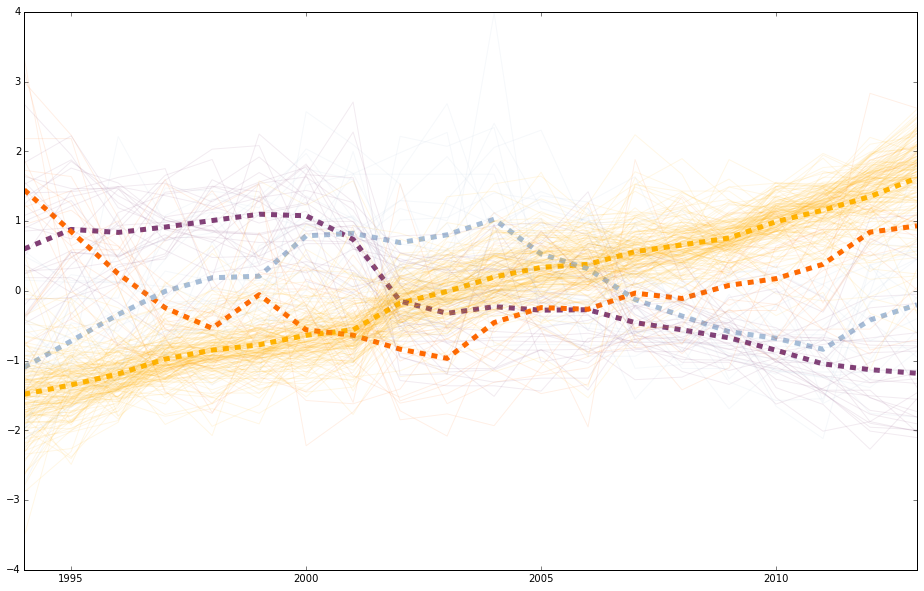

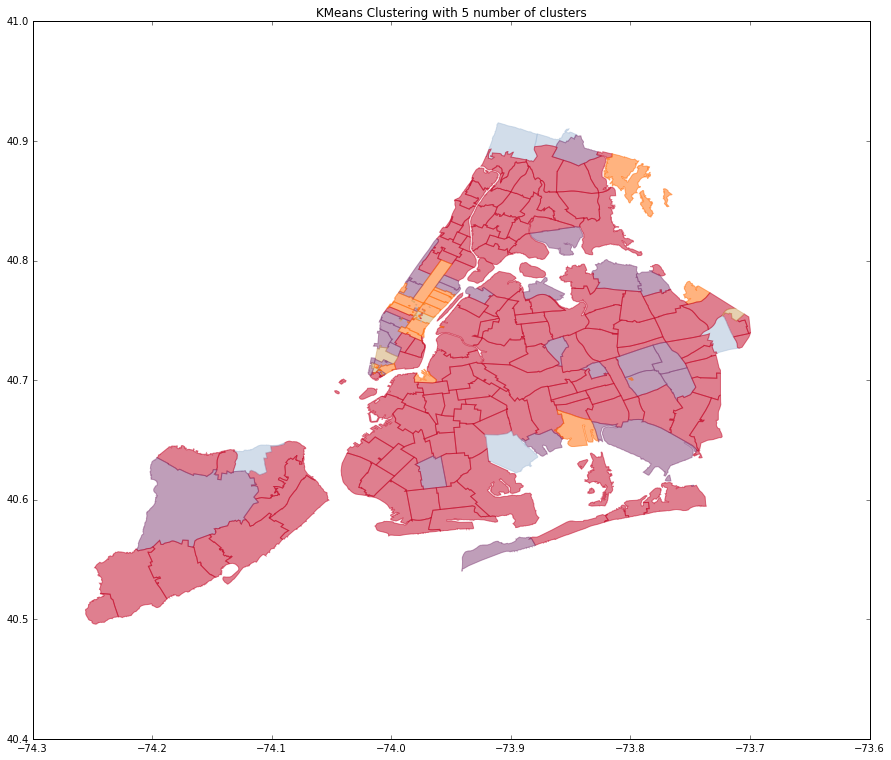

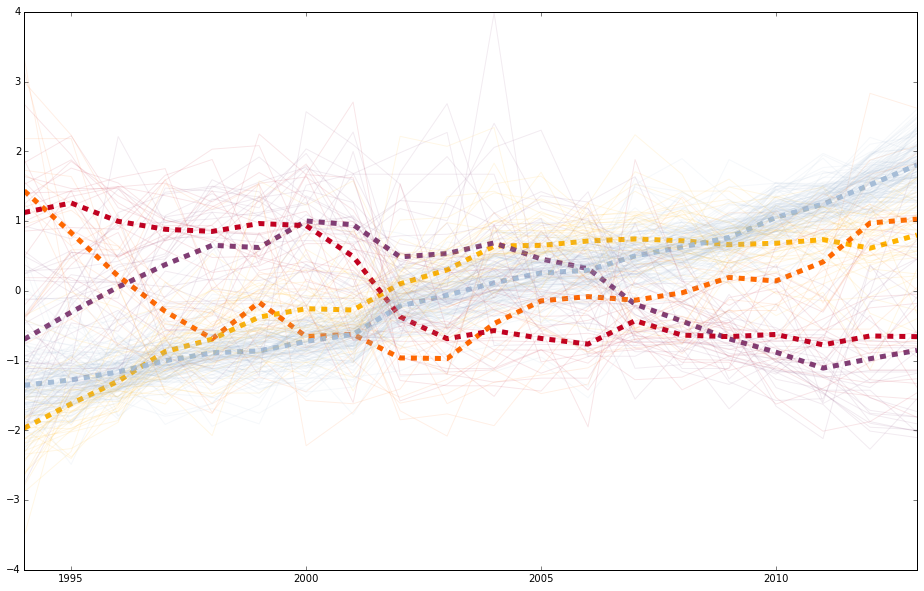

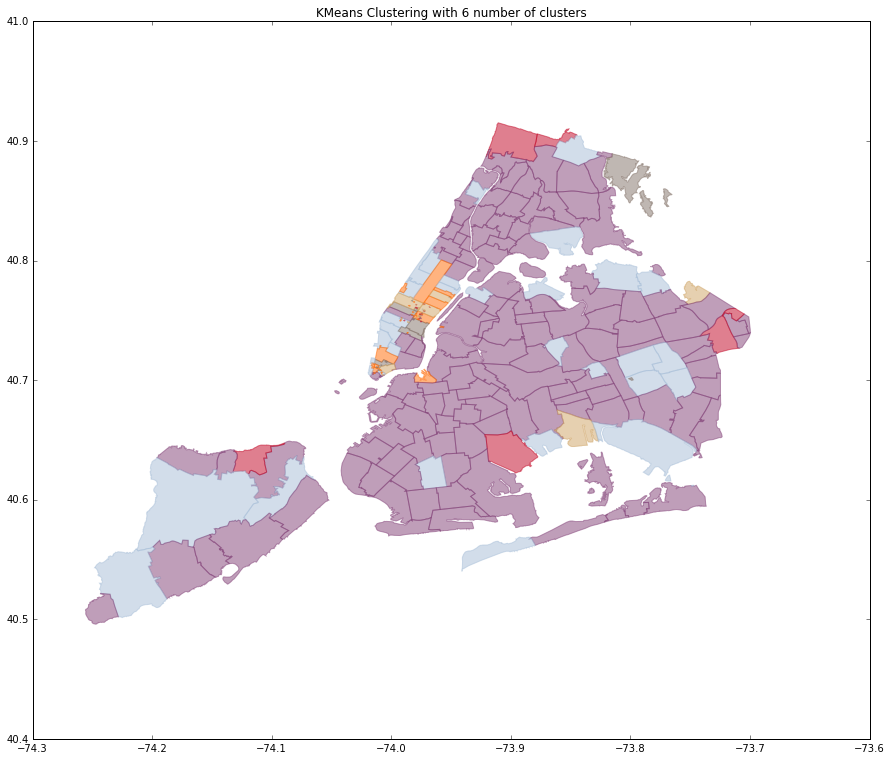

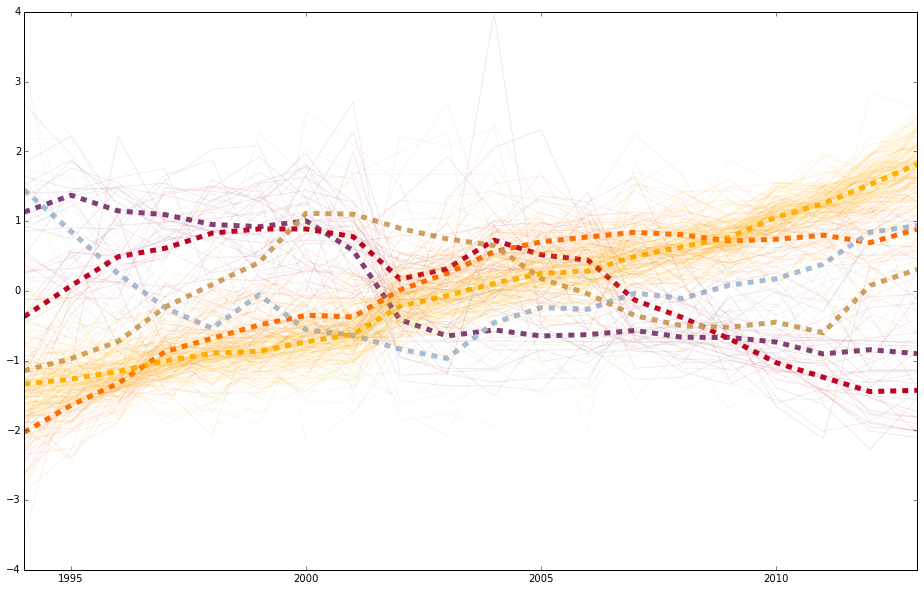

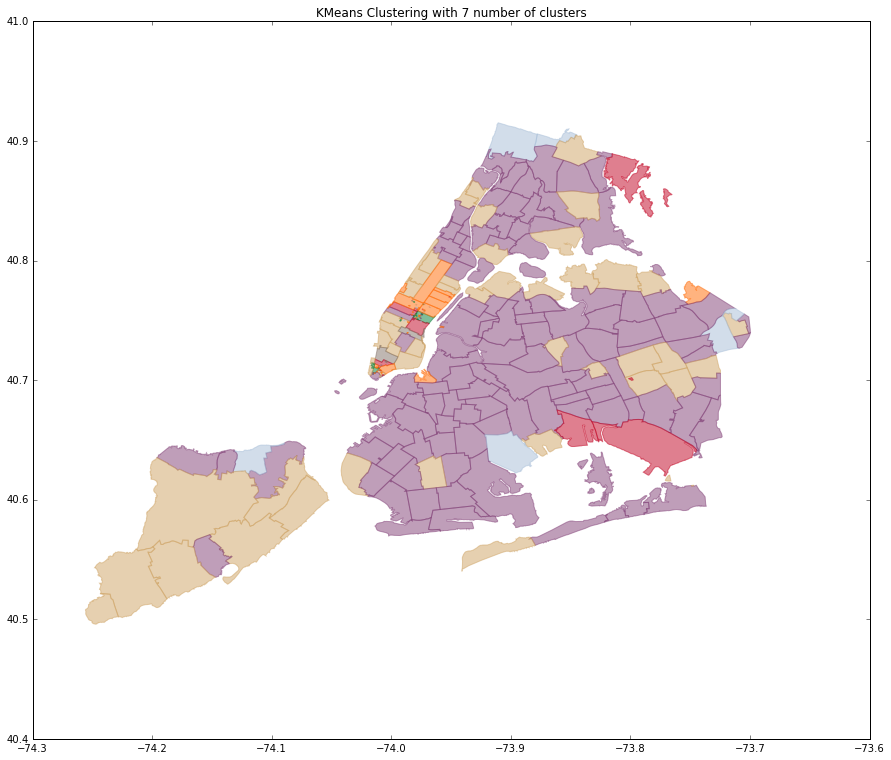

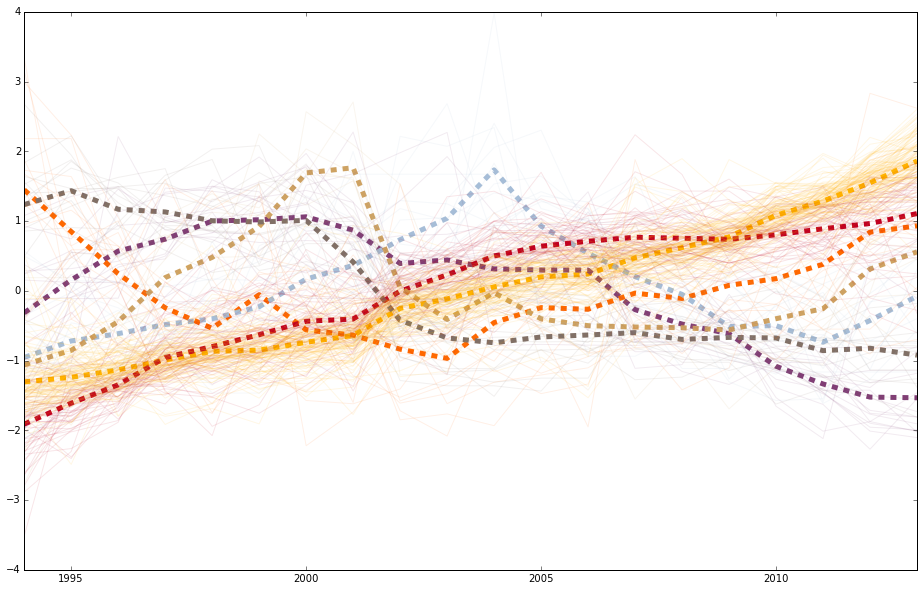

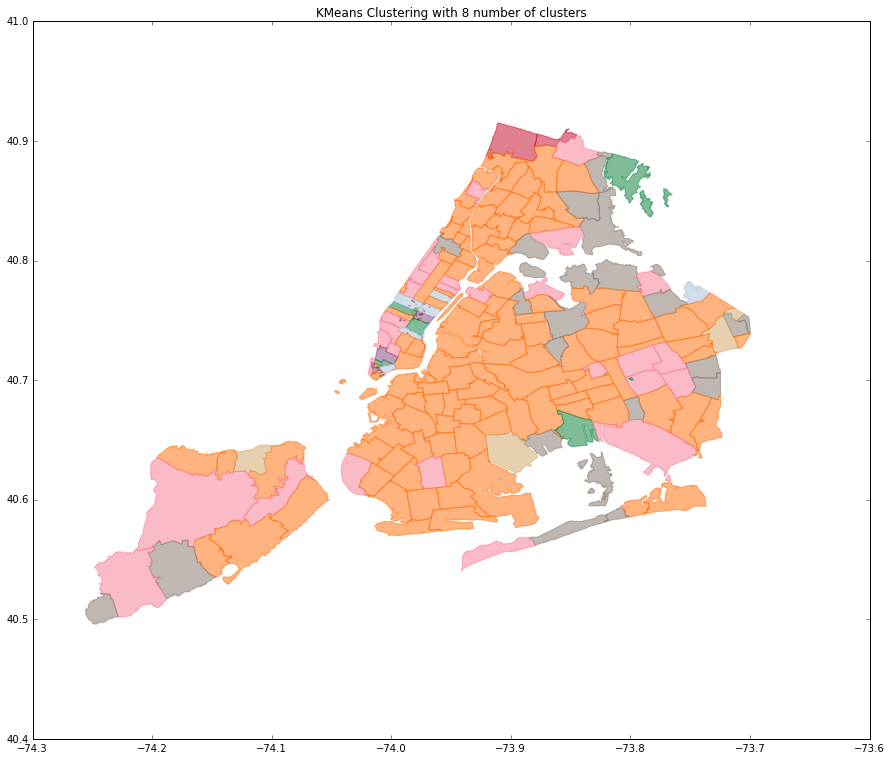

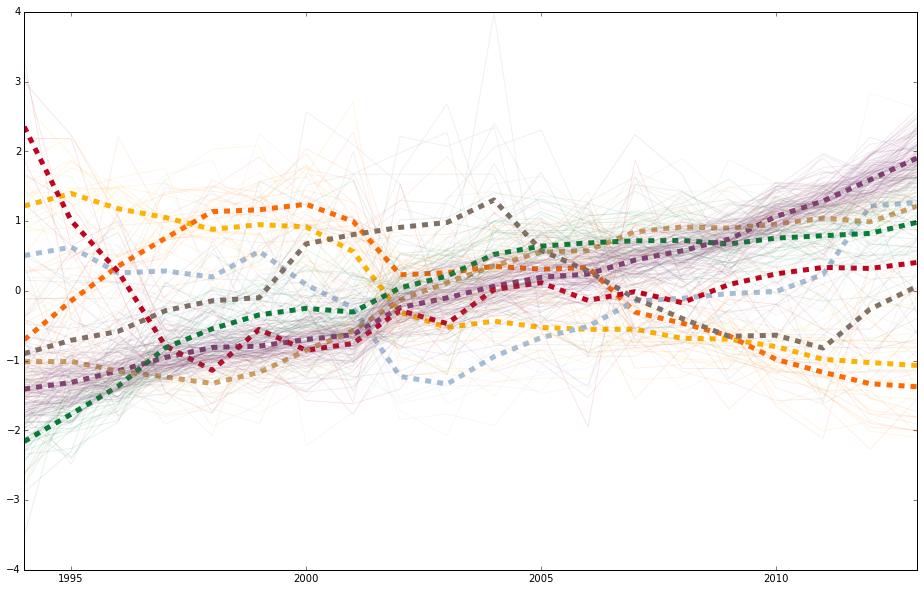

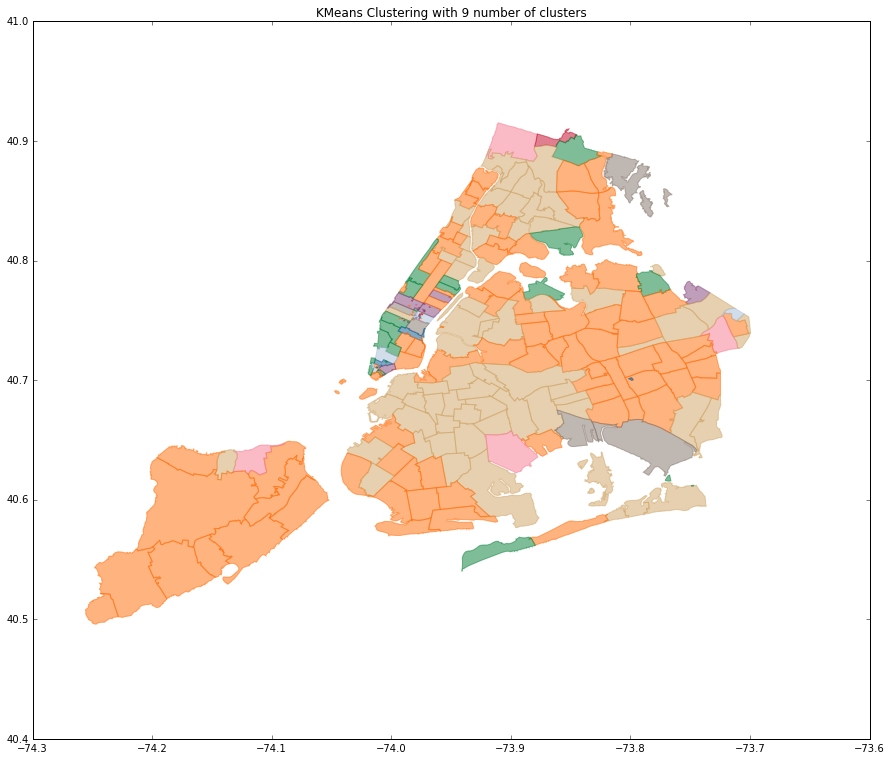

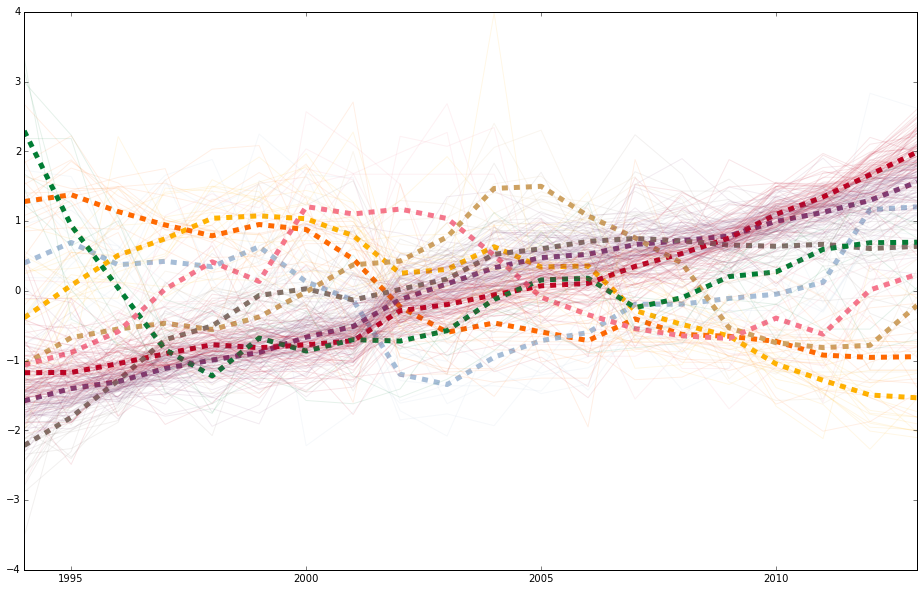

In [142]:
silhouette_scores = {}
for n in range(2,10):
    #Clustering
    kmeans = sklearn.cluster.KMeans(n_clusters=n)
    kmeans.fit(clean_frameZIP.values)
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_
    
    #Silhouette score
    
    silhouette_avg = silhouette_score(clean_frameZIP.values, kmeans.labels_)
    silhouette_scores[n] = silhouette_avg
    
    #Plotting 
    cluster = labels
    clustered_zips = pd.DataFrame({'zip':clean_frameZIP.index, 'cluster':cluster})
    fig = plt.figure(figsize=(15,15)) 
    for i in shapefile['features']:
        poly = i['geometry']
        postcode = int(i['properties']['postalCode'])
        ax = fig.gca()
        purple = kelly_colors_hex[2]
        if postcode in list(clean_frameZIP.index):
            color = kelly_colors_hex[int(clustered_zips[clustered_zips['zip']==postcode]['cluster'])+1]
            ax.add_patch(PolygonPatch(poly, fc=color, ec=color, alpha=0.5, zorder=2 ))
        else:
            ax.add_patch(PolygonPatch(poly, fc=purple, ec=purple, alpha=0.5, zorder=2 ))
    ax.axis('scaled')
    import matplotlib.patches as mpatches

    ground = mpatches.Patch(color=purple, alpha=0.5, label='Ground')
    plt.legend()
    plt.title('KMeans Clustering with %s number of clusters'%(n))
    plt.figure(figsize=(16,10))
    plt.xlim(1994,2013)
    for i in range(len(centers)):
        plt.plot(range(1994,2014),centers[i],'--',linewidth=5,alpha=1.0,c=kelly_colors_hex[i]) 
    for i in range(len(clean_frameZIP)):
        plt.plot(clean_frameZIP.iloc[i].index, clean_frameZIP.iloc[i],c=kelly_colors_hex[labels[i]],alpha=0.1)


In [130]:
for sc in silhouette_scores:
    print('For {0} number of centers  silhouette value={1}'.format(sc, silhouette_scores[sc]))

For 2 number of centers  silhouette value=0.561611135742
For 3 number of centers  silhouette value=0.521545977161
For 4 number of centers  silhouette value=0.42388512067
For 5 number of centers  silhouette value=0.259355625056
For 6 number of centers  silhouette value=0.215356416613
For 7 number of centers  silhouette value=0.212305985994
For 8 number of centers  silhouette value=0.156988269701
For 9 number of centers  silhouette value=0.173505460097


[0 1]
Silhouette Coefficient: 0.56473299576
Estimated number of clusters: 2


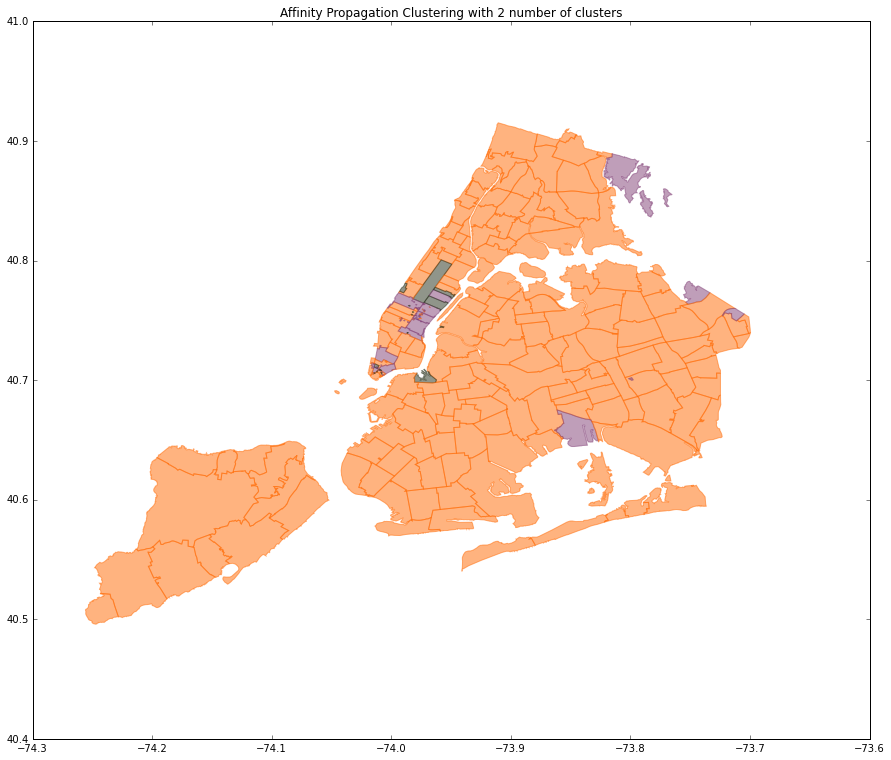

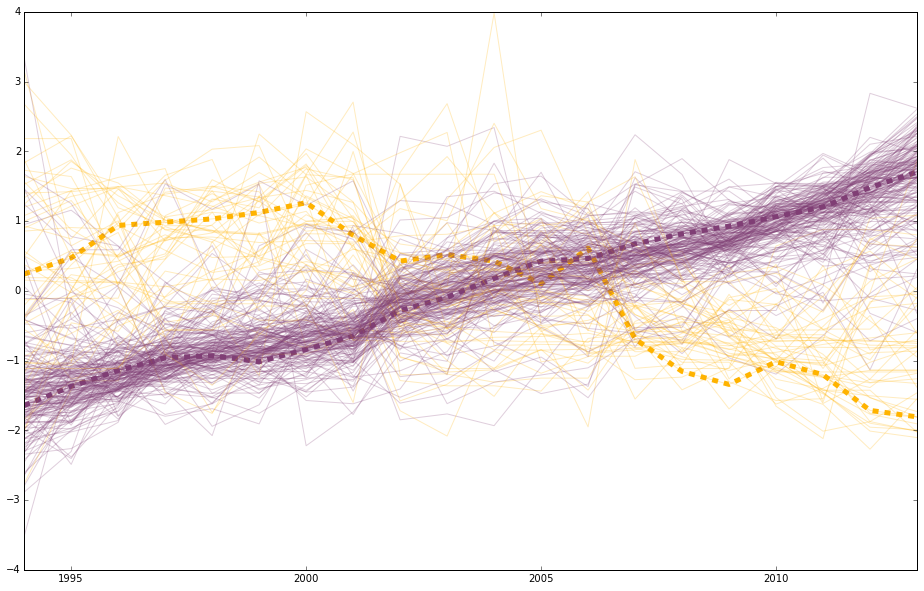

In [141]:
db = AffinityPropagation(preference=-350).fit(clean_frameZIP.values)

labels = (db.labels_).astype(int)
centers = db.cluster_centers_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

print(unique(labels))
print("Silhouette Coefficient: %s" % silhouette_score(clean_frameZIP.values, labels))
print('Estimated number of clusters: %d' % n_clusters)

cluster = labels
clustered_zips = pd.DataFrame({'zip':clean_frameZIP.index, 'cluster':cluster})
fig = plt.figure(figsize=(15,15)) 
for i in shapefile['features']:
    poly = i['geometry']
    postcode = int(i['properties']['postalCode'])
    ax = fig.gca()
    GREEN = kelly_colors_hex[19]
    if postcode in list(clean_frameZIP.index):
        color = kelly_colors_hex[int(clustered_zips[clustered_zips['zip']==postcode]['cluster'])+1]
        ax.add_patch(PolygonPatch(poly, fc=color, ec=color, alpha=0.5, zorder=2 ))
    else:
        ax.add_patch(PolygonPatch(poly, fc=GREEN, ec=GREEN, alpha=0.5, zorder=2 ))
ax.axis('scaled')
import matplotlib.patches as mpatches

ground = mpatches.Patch(color=GREEN, alpha=0.5, label='Ground')
plt.legend()
plt.title('Affinity Propagation Clustering with %s number of clusters'%(n_clusters))
plt.figure(figsize=(16,10))
plt.xlim(1994,2013)
for i in range(len(centers)):
    plt.plot(range(1994,2014),centers[i],'--',linewidth=5,alpha=1.0,c=kelly_colors_hex[i]) 
for i in range(len(clean_frameZIP)):
    plt.plot(clean_frameZIP.iloc[i].index, clean_frameZIP.iloc[i],c=kelly_colors_hex[labels[i]],alpha=0.25)

#The algorithms used in this subject are Kmeans and AffinityPropagation.
# The result of silhouette value in each method with the same name of clusters are:
Kmeans
For 2 number of centers  silhouette value=0.561611135742

Affinity propagation
Silhouette Coefficient: 0.56473299576
Estimated number of clusters: 2

The Silhouette Coefficient is better in the second method.
Interpretation:

Range of SCInterpretation

0.71-1.0A strong structure has been found

0.51-0.70A reasonable structure has been found

0.26-0.50The structure is weak and could be artificial

< 0.25No substantial structure has been found


